# Contact Graph Generator

In [1]:
import logging
from large_gcs.graph_generators.contact_graph_generator import (
    ContactGraphGeneratorParams,
    ContactGraphGenerator,
)
from large_gcs.graph.contact_graph import ContactGraph
from large_gcs.algorithms.search_algorithm import ReexploreLevel
from large_gcs.algorithms.gcs_astar import GcsAstar
from large_gcs.algorithms.gcs_astar_convex_restriction import GcsAstarConvexRestriction
from large_gcs.graph.contact_cost_constraint_factory import (
    contact_shortcut_edge_cost_factory_under,
    contact_shortcut_edge_cost_factory_over_obj_weighted,
)
from large_gcs.cost_estimators.shortcut_edge_ce import ShortcutEdgeCE
from large_gcs.contact.contact_regions_set import ContactRegionParams

import numpy as np
from copy import deepcopy
from IPython.display import HTML


np.set_printoptions(formatter={"float": lambda x: "{0:0.3f}".format(x)})
logging.basicConfig(level=logging.INFO)
# logging.getLogger().setLevel(logging.INFO)
logging.getLogger("drake").setLevel(logging.WARNING)

## Simple Demo 2

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04


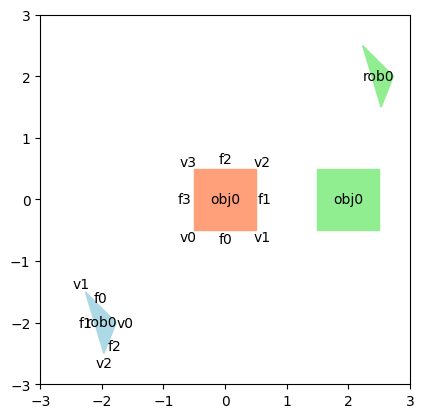

In [2]:
ws = 3
params = ContactGraphGeneratorParams(
    name="cg_simple_2",
    obs_vertices=[],
    obj_vertices=[np.array([[0, 0], [1, 0], [1, 1], [0, 1]]) + np.array([2.5, 0.5])],
    rob_vertices=[np.array([[-1, -1], [-1.5, -0.5], [-1.2, -1.5]])],
    source_obj_pos=[[0, 0]],
    source_rob_pos=[[-2, -2]],
    target_obj_pos=[[2, 0]],
    target_rob_pos=[[2.5, 2]],
    n_pos_per_set=2,
    workspace=[[-ws, ws], [-ws, ws]],
)
generator = ContactGraphGenerator(params)
generator.plot()

In [ ]:
generator.generate()

In [3]:
cg = ContactGraph.load_from_file(params.graph_file_path)

INFO:large_gcs.graph.contact_graph:Loading 11 contact pair modes for 2 bodies...
INFO:large_gcs.graph.contact_graph:Generating force constraints for 11 sets...
100%|██████████| 11/11 [00:00<00:00, 3367.94it/s]
INFO:large_gcs.graph.contact_graph:Generating contact sets for 11 sets...
100%|██████████| 11/11 [00:00<00:00, 43.98it/s]
INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 13/13 [00:00<00:00, 8145.50it/s]
INFO:large_gcs.graph.graph:Adding 13 vertices to graph...
100%|██████████| 13/13 [00:00<00:00, 9894.02it/s]
INFO:large_gcs.graph.contact_graph:Creating edge costs...
100%|██████████| 52/52 [00:00<00:00, 8765.88it/s]
INFO:large_gcs.graph.contact_graph:Creating edge constraints...
100%|██████████| 52/52 [00:00<00:00, 3436.82it/s]
INFO:large_gcs.graph.graph:Adding 52 edges to graph...
100%|██████████| 52/52 [00:00<00:00, 3988.29it/s]
INFO:large_gcs.graph.contact_graph:Created contact graph: GraphParams(dim_bounds=(4, 16), n_vertices=13, n_edges=52, source

In [ ]:
cost_estimator = ShortcutEdgeCE(cg, shortcut_edge_cost_factory=contact_shortcut_edge_cost_factory_over_obj_weighted)
gcs_astar = GcsAstarConvexRestriction(
    cg,
    cost_estimator=cost_estimator,
    reexplore_level=ReexploreLevel.FULL,
)
sol = gcs_astar.run()

In [ ]:
cost_estimator = ShortcutEdgeCE(cg, shortcut_edge_cost_factory=contact_shortcut_edge_cost_factory_under)
gcs_astar = GcsAstar(
    cg,
    cost_estimator=cost_estimator,
    use_convex_relaxation=False,
)
sol = gcs_astar.run()

In [ ]:
sol = cg.solve(use_convex_relaxation=False)
print(sol)

In [ ]:
sol = cg.solve(use_convex_relaxation=True)
print(sol)

## Simple Demo 3 (Target Region)

In [ ]:
ws = 3
target_regions = [
    ContactRegionParams(region_vertices=[[1.5,-1], [1.5,1], [3,1], [3,-1]],
                  obj_indices=[0]),
]

params = ContactGraphGeneratorParams(
    name="cg_simple_3",
    obs_vertices=[],
    obj_vertices=[np.array([[0, 0], [1, 0], [1, 1], [0, 1]]) + np.array([2.5, 0.5])],
    rob_vertices=[np.array([[-1, -1], [-1.5, -0.5], [-1.2, -1.5]])],
    source_obj_pos=[[0, 0]],
    source_rob_pos=[[-2, -2]],
    target_region_params=target_regions,
    n_pos_per_set=2,
    workspace=[[-ws, ws], [-ws, ws]],
)
generator = ContactGraphGenerator(params)
generator.plot()

In [ ]:
generator.generate()

## Triangle Challenge 2

In [ ]:
ws_x = 5
ws_y = 4
params = ContactGraphGeneratorParams(
    name="cg_trichal2",
    obs_vertices=[[[-1, 2], [-1, -1], [2, 2]]],
    obj_vertices=[[[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]]],
    rob_vertices=[[[3, 1], [3, 0], [3.5, 0]]],
    source_obj_pos=[[3.25, 0]],
    source_rob_pos=[[1.5, 0.5]],
    target_obj_pos=[[-1.5, 0]],
    target_rob_pos=[[-3, 0]],
    n_pos_per_set=2,
    workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
)

generator = ContactGraphGenerator(params)
generator.plot()

In [ ]:
generator.generate()

In [ ]:
cg = ContactGraph.load_from_file(params.graph_file_path)

Just checking that everything works

In [ ]:
cost_estimator = ShortcutEdgeCE(cg, shortcut_edge_cost_factory=contact_shortcut_edge_cost_factory_over_obj_weighted)
gcs_astar = GcsAstarConvexRestriction(
    cg,
    cost_estimator=cost_estimator,
    reexplore_level=ReexploreLevel.NONE,
)
sol = gcs_astar.run()

In [ ]:
anim = cg.animate_solution()
HTML(anim.to_html5_video())

In [ ]:
ws_x = 5
ws_y = 4
params = ContactGraphGeneratorParams(
    name="cg_trichal3",
    obs_vertices=[[[-1, 2], [-1, -1], [2, 2]]],
    obj_vertices=[[[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]]],
    rob_vertices=[[[3, 1], [3, 0], [3.5, 0]]],
    source_obj_pos=[[3.25, 0]],
    source_rob_pos=[[-3, 0]],
    target_obj_pos=[[-1.5, 0]],
    target_rob_pos=[[1.5, 0.5]],
    n_pos_per_set=2,
    workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
)

generator = ContactGraphGenerator(params)
generator.plot()

In [ ]:
generator.generate()

In [ ]:
cg = ContactGraph.load_from_file(params.graph_file_path)

In [ ]:
ws_x = 5
ws_y = 5
params = ContactGraphGeneratorParams(
    name="cg_maze_a1",
    obs_vertices=[
        [[-2, -2.7], [2.2, 2.6], [-1.3, 0.5]],
        [[0.5, -2], [2.7, -1.2], [2.4, 0.3]],
    ],
    obj_vertices=[[[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]]],
    rob_vertices=[[[3, 1], [3, 0], [3.5, 0]]],
    source_obj_pos=[[3.25, 0]],
    source_rob_pos=[[1.5, 0.6]],
    target_obj_pos=[[-2.3, -0.7]],
    target_rob_pos=[[-0.5, 2]],
    n_pos_per_set=2,
    workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
)

generator = ContactGraphGenerator(params)
generator.plot()

In [ ]:
generator.generate()

In [ ]:
cg = ContactGraph.load_from_file(params.graph_file_path)

## Triangle Challenge 4 (Target Region)

In [ ]:
ws_x = 5
ws_y = 4
target_region_params = [
    ContactRegionParams(region_vertices=[[-3,-0.75], [-3,1], [-1,-0.75], [-1,1]],
                  obj_indices=[0]),
]
params = ContactGraphGeneratorParams(
    name="cg_trichal4",
    obs_vertices=[[[-1, 2], [-1, -1], [2, 2]]],
    obj_vertices=[[[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]]],
    rob_vertices=[[[3, 1], [3, 0], [3.5, 0]]],
    source_obj_pos=[[3.25, 0]],
    source_rob_pos=[[1.5, 0.5]],
    target_region_params=target_region_params,
    n_pos_per_set=2,
    workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
)

generator = ContactGraphGenerator(params)
generator.plot()

In [ ]:
generator.generate()

## Maze a2

In [ ]:
ws_x = 5
ws_y = 5
params = ContactGraphGeneratorParams(
    name="cg_maze_a2",
    obs_vertices=[
        [[-2, -2.7], [2.2, 2.6], [-1.3, 0.5]],
        [[0.5, -2], [2.7, -1.2], [2.4, 0.3]],
    ],
    obj_vertices=[[[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]]],
    rob_vertices=[[[3, 1], [3, 0], [3.5, 0]]],
    source_obj_pos=[[1.6, 0.6]],
    source_rob_pos=[[3.25, 0]],
    target_obj_pos=[[-2.3, -0.7]],
    target_rob_pos=[[-0.5, 2]],
    n_pos_per_set=2,
    workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
)

generator = ContactGraphGenerator(params)
generator.plot()

In [ ]:
generator.generate()

In [ ]:
cg = ContactGraph.load_from_file(params.graph_file_path)

## StackPush

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04


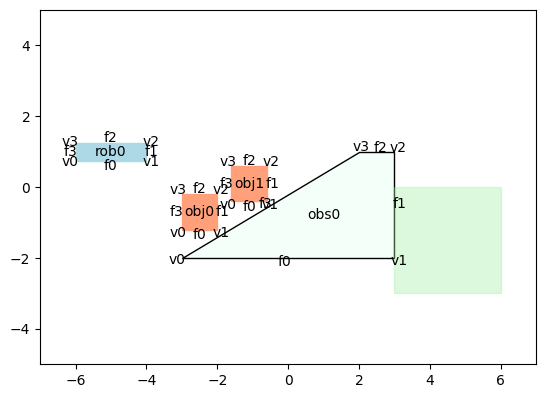

In [2]:
ws_x = 7
ws_y = 5
target_region_params = [
    ContactRegionParams(region_vertices=[[3,0], [3,-3], [6,0], [6,-3]],
                  obj_indices=[0]),
]
params = ContactGraphGeneratorParams(
    name="cg_stackpush_a1",
    obs_vertices=[[[-3, -2], [2, 1], [3, 1], [3, -2] ]],
    obj_vertices=[[[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],
                  [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],],
    rob_vertices=[[[0, 0], [0, 0.5], [2, 0], [2, 0.5]]],
    source_obj_pos=[[-2.5, -0.7], [-1.1, 0.1]],
    source_rob_pos=[[-5, 1]],
    target_region_params=target_region_params,
    n_pos_per_set=2,
    workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
)

generator = ContactGraphGenerator(params)
generator.plot()

In [3]:
generator.generate()

INFO:large_gcs.graph.contact_graph:Generating contact sets for 4 bodies...
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 6 body pairs...
100%|██████████| 6/6 [00:00<00:00, 51.28it/s]
INFO:large_gcs.graph.contact_graph:Each body pair has on average 7.666666666666667 modes
INFO:large_gcs.graph.contact_graph:Generating force constraints for 165888 sets...
100%|██████████| 165888/165888 [01:02<00:00, 2643.69it/s]
INFO:large_gcs.graph.contact_graph:Generating contact sets for 165888 sets...
  2%|▏         | 4007/165888 [01:23<58:06, 46.44it/s]  

KeyboardInterrupt: 

  2%|▏         | 4007/165888 [01:37<58:06, 46.44it/s]

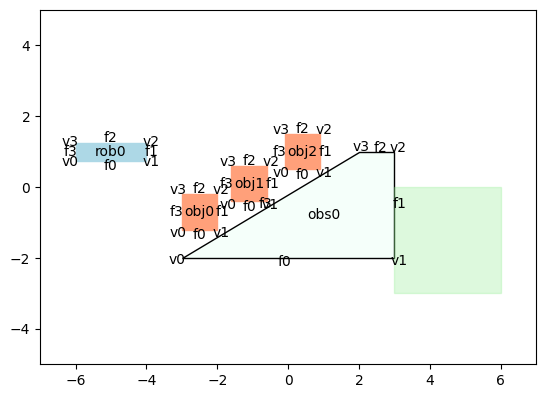

In [4]:
ws_x = 7
ws_y = 5
target_region_params = [
    ContactRegionParams(region_vertices=[[3,0], [3,-3], [6,0], [6,-3]],
                  obj_indices=[0,1,2]),
]
params = ContactGraphGeneratorParams(
    name="cg_stackpush",
    obs_vertices=[[[-3, -2], [2, 1], [3, 1], [3, -2] ]],
    obj_vertices=[[[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],
                  [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],
                  [[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]],],
    rob_vertices=[[[0, 0], [0, 0.5], [2, 0], [2, 0.5]]],
    source_obj_pos=[[-2.5, -0.7], [-1.1, 0.1], [0.4, 1]],
    source_rob_pos=[[-5, 1]],
    target_region_params=target_region_params,
    n_pos_per_set=2,
    workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
)

generator = ContactGraphGenerator(params)
generator.plot()

In [5]:
generator.generate()

INFO:large_gcs.graph.contact_graph:Generating contact sets for 5 bodies...
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 10 body pairs...
100%|██████████| 10/10 [00:00<00:00, 53.46it/s]